<a href="https://colab.research.google.com/github/HyungjoByun/Projects/blob/main/Faster%20RCNN/Faster_RCNN_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/Cartucho/mAP.git
!pip install imgaug --upgrade
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import xml.etree.ElementTree as Et
from xml.etree.ElementTree import Element, ElementTree
import torchvision
import cv2
from imgaug import augmenters as iaa

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 29.54 MiB/s, done.
Resolving deltas: 100% (321/321), done.
     |████████████████████████████████| 952kB 6.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [ ]:
if not os.path.isfile("/content/voc_test_2007_tar"):
  !cp "/content/drive/MyDrive/Faster_RCNN/VOCtest_06-Nov-2007.tar" "/content/voc_test_2007_tar" 
  ! tar -xf "/content/voc_test_2007_tar"

In [ ]:
def xml_parser(xml_path):
  xml_path = xml_path


  xml = open(xml_path, "r")
  tree = Et.parse(xml)
  root = tree.getroot()

  size = root.find("size")

  file_name = root.find("filename").text

  object_name = []
  bbox = []

  objects = root.findall("object")
  for _object in objects:
      name = _object.find("name").text
      object_name.append(name)
      bndbox = _object.find("bndbox")
      one_bbox = []
      xmin = bndbox.find("xmin").text
      one_bbox.append(int(float(xmin)))
      ymin = bndbox.find("ymin").text
      one_bbox.append(int(float(ymin)))


      xmax = bndbox.find("xmax").text
      one_bbox.append(int(float(xmax)))
      ymax = bndbox.find("ymax").text
      one_bbox.append(int(float(ymax)))
      

      bbox.append(one_bbox)
  
  return file_name, object_name, bbox


In [ ]:
def makeBox(voc_im,bbox,objects):
  image = voc_im.copy()
  for i in range(len(objects)):
    cv2.rectangle(image,(int(bbox[i][0]),int(bbox[i][1])),(int(bbox[i][2]),int(bbox[i][3])),color = (0,255,0),thickness = 1)
    cv2.putText(image, objects[i], (int(bbox[i][0]), int(bbox[i][1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2) # 크기, 색, 굵기
  return image

In [ ]:
xml_list = os.listdir("/content/VOCdevkit/VOC2007/Annotations/")
xml_list.sort()
print(len(xml_list))
label_set = set()

for i in range(len(xml_list)):
  xml_path = "/content/VOCdevkit/VOC2007/Annotations/"+str(xml_list[i])
  file_name, object_name, bbox = xml_parser(xml_path)
  for name in object_name:
    label_set.add(name)

label_set = sorted(list(label_set))

label_dic = {}

label_dic['background'] = 0

for i, key in enumerate(label_set):
  label_dic[key] = (i+1)

print(label_dic)

4952
{'background': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


In [ ]:
def make_info_txt(file_name, object_name, bbox, mode, scores = None):
  if mode == 'gt':
    with open("/content/mAP/input/ground-truth/{}.txt".format(file_name[:-4]),"w") as f:
      for i in range(len(object_name)):
        f.write("{} ".format(object_name[i])+" ".join(map(str,map(int,bbox[i])))+"\n")
  
  if mode == 'rt':
    assert scores != None
    with open("/content/mAP/input/detection-results/{}.txt".format(file_name[:-4]),"w") as f:
      for i in range(len(object_name)):
        f.write("{} ".format(object_name[i])+"{} ".format(scores[i])+" ".join(map(str,map(int,bbox[i])))+"\n")

In [ ]:
def evaluation(xml_list, new = False):
  if new == True:
    print("Clear Directory")
    filelist = [ f for f in os.listdir("/content/mAP/input/ground-truth")]
    for f in filelist:
      os.remove(os.path.join("/content/mAP/input/ground-truth", f)) 
    
    filelist = [ f for f in os.listdir("/content/mAP/input/detection-results")]
    for f in filelist:
      os.remove(os.path.join("/content/mAP/input/detection-results", f)) 

    print("Evaluating")
    model.eval()
    for i in range(len(xml_list)):
      xml_path = "/content/VOCdevkit/VOC2007/Annotations/"+str(xml_list[i])
      file_name, object_name, bbox = xml_parser(xml_path)
      image_path = "/content/VOCdevkit/VOC2007/JPEGImages/"+str(file_name)

      test_image = Image.open(image_path).convert("RGB")
      test_image = np.array(test_image)
      resize = iaa.Resize({"shorter-side": 600, "longer-side": "keep-aspect-ratio"})
      to_tensor = torchvision.transforms.ToTensor()
      
      test_image,bbox = resize(image = test_image,bounding_boxes = np.array([bbox]))
      make_info_txt(file_name, object_name, bbox.squeeze(0),mode='gt')

      
      test_image = to_tensor(test_image).unsqueeze(0)
      predictions = model(test_image.to(device))
      object_name = []
      boxes = predictions[0]['boxes']
      labels = predictions[0]['labels']
      scores = predictions[0]['scores']
      for lb in labels:
        object_name.append([k for k, v in label_dic.items() if v == lb][0])
      
      make_info_txt(file_name, object_name, boxes, mode='rt', scores = scores)
  
  print("Result")
  f = os.popen("python /content/mAP/main.py --no-animation ") #openCV작동 안해서 --no-animation
  print(f.read())
  

In [ ]:
backbone = torchvision.models.vgg16(pretrained=True).features[:-1]
backbone_out = 512
backbone.out_channels = backbone_out

anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((128, 256, 512),),aspect_ratios=((0.5, 1.0, 2.0),))

resolution = 7
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=resolution, sampling_ratio=2)

box_head = torchvision.models.detection.faster_rcnn.TwoMLPHead(in_channels= backbone_out*(resolution**2),representation_size=4096) 
box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(4096,21) #21개 class

model = torchvision.models.detection.FasterRCNN(backbone, num_classes=None,
                   min_size = 600, max_size = 1000,
                   rpn_anchor_generator=anchor_generator,
                   rpn_pre_nms_top_n_train = 6000, rpn_pre_nms_top_n_test = 6000,
                   rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=300,
                   rpn_nms_thresh=0.7,rpn_fg_iou_thresh=0.7,  rpn_bg_iou_thresh=0.3,
                   rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                   box_roi_pool=roi_pooler, box_head = box_head, box_predictor = box_predictor,
                   box_score_thresh=0.6, box_nms_thresh=0.5,box_detections_per_img=300,
                   box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                   box_batch_size_per_image=128, box_positive_fraction=0.25
                 )

model.to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Faster_RCNN/Epoch29.pth",map_location=device)) #epoch지정

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Answer>
['motorbike'] [[341, 137, 456, 333]]
<Prediction>
motorbike :  [339.05535888671875, 140.1695556640625, 456.133056640625, 333.0]


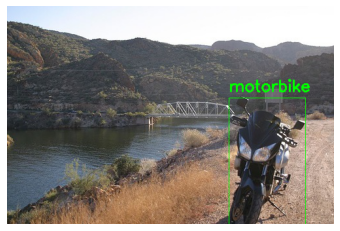

In [ ]:
#Sample
xml_path = "/content/VOCdevkit/VOC2007/Annotations/"+str(xml_list[np.random.randint(0,5000)])
file_name, object_name, bbox = xml_parser(xml_path)
image_path = "/content/VOCdevkit/VOC2007/JPEGImages/"+str(file_name)
test_image = Image.open(image_path).convert("RGB")
test_image = np.array(test_image)

to_tensor = torchvision.transforms.ToTensor()

test_image = to_tensor(test_image).unsqueeze(0)


targets = []
d = {}
d['boxes'] = torch.tensor(bbox,device=device)
d['labels'] = torch.tensor([label_dic[x] for x in object_name],dtype=torch.int64,device = device)
targets.append(d)
model.eval()
predictions = model(test_image.to(device))
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']

print("<Answer>")
print(object_name, bbox)

print("<Prediction>")
objects = []
for lb in labels:
  objects.append([k for k, v in label_dic.items() if v == lb][0])

for a,b in zip(objects, boxes):
  print(a,": ",b.tolist())

plot_image = test_image.squeeze().permute(1,2,0).numpy()
answer = makeBox(plot_image,boxes,objects)
plt.axis('off')
plt.imshow(answer)

In [ ]:
evaluation(xml_list,new=True) #파일 만들어야하면 True, 아니면 False